<a href="https://colab.research.google.com/github/LeeSeungwon89/Kaggle_Dacon_Practice/blob/main/Titanic_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kspecial","key":"f8001557e122f2fd5c4147474793f59c"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 참가한 대회 리스트를 확인합니다.
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                    2030-07-01 23:59:00  Getting Started     Prizes         60           False  
gan-getting-started                             2030-07-01 23:59:00  Getting Started     Prizes         90           False  
store-sales-time-series-forecasting             2030-06-30 23:59:00  Getting Started  Knowledge        719           False  
tpu-getting-started                             2030-06-03 23:59:00  Getting Started  Knowledge        138           False  
digit-recognizer                                2030-01-01 00:00:00  Getting Started  Knowledge       1239           False  
titanic                                         2030-01-01 00:00:00  Getting Started  Knowledge      13938            True  


In [4]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 22.8MB/s]


In [5]:
!ls

kaggle.json  sample_data  titanic.zip


In [6]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **데이터 준비**

In [7]:
import numpy as np
import pandas as pd

# 최대 행렬 수를 설정합니다.
pd.set_option('display.max_column', 50)
pd.set_option('display.max_rows', 50)

# 데이터를 읽습니다.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

데이터 사이즈가 크지 않으므로 난수에 따라 결과가 달라지기 쉽습니다. 랜덤 시드를 설정하겠습니다. 

In [8]:
import random
np.random.seed(2022)
random.seed(2022)

# **데이터 확인**

## **데이터 개요**

데이터를 살펴보겠습니다. 

In [9]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [10]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [11]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


'Survived' 피처를 예측하는 문제이므로 테스트 세트에는 'Survived' 피처가 없습니다.

## **피처 개요**

훈련 세트와 테스트 세트를 결합하여 수행하는 것이 좋지만 일단 그대로 진행해 보겠습니다.

### **피처 요약**

피처를 요약하는 함수를 선언하여 데이터 크기, 피처 타입, 결측치 개수, 고윳값 개수를 출력해 보겠습니다.

In [14]:
def feature_table(df):
    # 피처 이름과 타입을 출력합니다.     
    feature_description = pd.DataFrame(df.dtypes, columns=['type'])
    feature_description = feature_description.reset_index()
    feature_description = feature_description.rename(columns={'index': 'feature'})
    # 결측치 개수를 산출합니다.
    feature_description['null count'] = df.isnull().sum().values
    # 고윳값 개수를 산출합니다.
    feature_description['eigenvalue count'] = df.nunique().values
    
    # 데이터 크기를 출력합니다.    
    print(df.shape)
    
    return feature_description

In [15]:
feature_table(train)

(891, 12)


,feature,type,null count,eigenvalue count
0,PassengerId,int64,0,891
1,Survived,int64,0,2
2,Pclass,int64,0,3
3,Name,object,0,891
4,Sex,object,0,2
5,Age,float64,177,88
6,SibSp,int64,0,7
7,Parch,int64,0,7
8,Ticket,object,0,681
9,Fare,float64,0,248


In [16]:
feature_table(test)

(418, 11)


,feature,type,null count,eigenvalue count
0,PassengerId,int64,0,418
1,Pclass,int64,0,3
2,Name,object,0,418
3,Sex,object,0,2
4,Age,float64,86,79
5,SibSp,int64,0,7
6,Parch,int64,0,8
7,Ticket,object,0,363
8,Fare,float64,1,169
9,Cabin,object,327,76


결측치가 존재하는 피처는 4개입니다. 특히 'Cabin' 피처의 경우 결측치가 너무 많습니다.

### **Survived**

몇몇 피처와 'Survieved' 피처의 관계를 확인해 보겠습니다. 'PassengerId', 'Name', 'Ticket' 피처는 데이터 분석에 큰 영향이 없을 것으로 일견 추정하지만 간략하게나마 살펴보겠습니다.

먼저 'Survived' 피처의 비율을 확인해 보겠습니다.

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mpl.rc('font', size=20)
plt.style.use('ggplot')

0    549
1    342
Name: Survived, dtype: int64


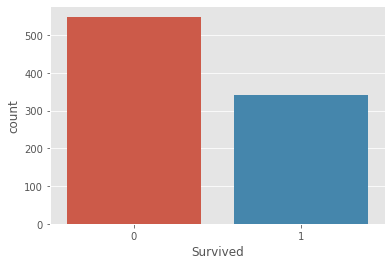

In [18]:
print(train['Survived'].value_counts())
sns.countplot(x='Survived', data=train)

사망자 수가 더 많습니다.

### **PassengerId**

'PassengerId' 피처는 승선객마다 하나씩 부여된 피처이므로 추후에 제거해도 무방합니다. 

### **Pclass**

'Pclass', 'Survived' 피처의 관계를 확인해 보겠습니다. 아래 두 코드는 같은 결괏값을 나타냅니다.

In [19]:
train[['Pclass', 'Survived', 'PassengerId']].groupby(['Pclass', 'Survived']).count().unstack()

PassengerId     
Survived           0    1
Pclass                   
1                 80  136
2                 97   87
3                372  119

In [20]:
pd.crosstab(train['Pclass'], train['Survived'], margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


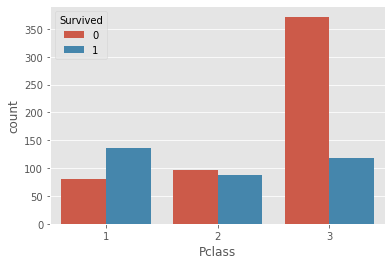

In [21]:
sns.countplot(x='Pclass', hue='Survived', data=train)

1등급은 생존자 수가 더 많고, 2등급은 큰 차이가 없으며, 3등급은 사망자 수가 더 많습니다. 티켓 등급이 낮을수록 사망자 수가 더 많습니다.

### **Name**

'Name' 피처의 클래스 형태를 살펴보겠습니다.

In [22]:
train['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

성씨, 호칭, 이름 순인 형태입니다. 성씨와 이름으로는 특징을 파악할 수 없지만 호칭은 'Sex', 'Age' 피처와 관계가 있을 것으로 추정합니다. 호칭을 따로 추출하여 고윳값 종류를 파악해 보겠습니다.

In [25]:
# 판다스의 `extract()` 메서드는 결괏값을 데이터프레임으로 출력합니다.
# 판다스의 `unique()` 메서드는 value를 받으므로 특정 컬럼을 지정합니다.
print(train['Name'].str.extract('([A-Za-z]*)\.')[0].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


여러 호칭이 존재합니다. 'Appellation', 'Survived' 피처의 관계, ''Appellation', 'Sex' 피처의 관계를 파악해 보겠습니다.

In [27]:
pd.crosstab(train['Survived'], train['Appellation'], margins=True)

Appellation,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,All
Survived,,,,,,,,,,,,,,,,,,
0,1,1,0,1,4,1,0,1,17,55,0,0,436,26,0,6,0,549
1,0,1,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,342
All,1,2,1,1,7,1,1,2,40,182,2,1,517,125,1,6,1,891


In [26]:
train['Appellation'] = train['Name'].str.extract('([A-Za-z]*)\.')
pd.crosstab(train['Sex'], train['Appellation'], margins=True)

Appellation,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,All
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0,314
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1,577
All,1,2,1,1,7,1,1,2,40,182,2,1,517,125,1,6,1,891


레이블 개수가 많으므로 각 레이블을 대표하는 레이블로 변환하여 레이블 개수를 간략화할 필요가 있다고 판단합니다. 값의 개수가 적은 레이블을 값의 개수가 많은 레이블에 포함시키겠습니다. 즉, 'Master', 'Miss', 'Mr', 'Mrs'를 그대로 사용하고, 나머지 레이블을 이 레이블로 치환하는 것입니다. 각 레이블이 의미하는 바를 파악할 필요가 있습니다. 레이블의 의미를 추정해보면 아래와 같습니다. 검색을 거쳤지만 정확하지 않을 수 있습니다. 

- 사용할 레이블

 - Mr: 일반 남성
 - Master: 어린 남자 아이
 - Miss: 'Mrs'보다 어린 미혼 여성
 - Mrs: 'Miss'보다 나이 많은 기혼 여성

- 치환할 레이블

 - Capt: 선장 또는 대령(남성 1명) -> 'Mr'
 - Col: 대령(남성 2명) -> 'Mr'
 - Countess: 여자 백작(여성 1명) -> 'Mrs'
 - Don: 스페인 사람 또는 큰 인물(남성 1명) -> 'Mr'
 - Dr: 의사(여성 1명, 남성 6명) -> 'Mr'(남성 비율이 높으므로 일단 'Mr'로 치환)
 - Jonkheer: 네덜란드 귀족(남성 1명) -> 'Mr'
 - Lady: 영국 귀부인(여성 1명) -> 'Mrs'
 - Major: 소령(남성 2명) -> 'Mr'
 - Mlle: 미혼 여성(여성 2명) -> 'Miss'
 - Mme: 부인(여성 1명) -> 'Mrs'
 - Ms: 혼인 여부에 상관 없는 여성(여성 1명) -> 'Miss'(기준이 모호하므로 최빈값으로 치환)
 - Rev: 목사(남성 6명) -> 'Mr'
 - Sir: 영국 기사 또는 준남작(남성 1명) -> 'Mr'

 레이블을 치환하겠습니다.

In [28]:
train['Appellation'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Mlle', 'Mme', 'Ms', 'Rev', 'Sir'],
                          ['Mr', 'Mr', 'Mrs', 'Mr', 'Mr', 'Mr', 'Mrs', 'Mr', 'Miss', 'Mrs', 'Miss', 'Mr', 'Mr'], inplace=True)

다시 피처를 비교해 보겠습니다. 'Appellation', 'Sex' 피처의 관계를 확인해 보겠습니다.

In [86]:
pd.crosstab(train['Sex'], train['Appellation'], margins=True)

Appellation,Master,Miss,Mr,Mrs,All
Sex,,,,,
female,0,185,1,128,314
male,40,0,537,0,577
All,40,185,538,128,891


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

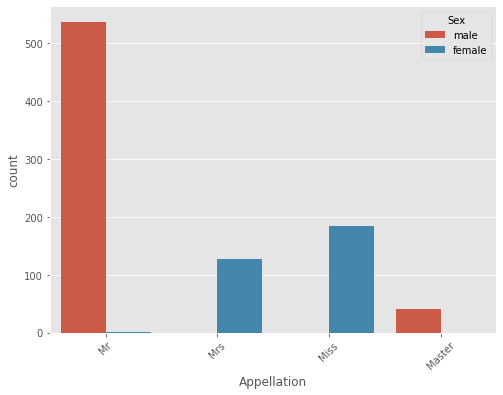

In [84]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Appellation', hue='Sex', data=train)
plt.xticks(rotation=45)

'Mr' 피처에 여성 1명이 포함된 이유는 'Dr' 레이블 때문입니다.

'Appellation', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [87]:
pd.crosstab(train['Survived'], train['Appellation'], margins=True)

Appellation,Master,Miss,Mr,Mrs,All
Survived,,,,,
0,17,55,451,26,549
1,23,130,87,102,342
All,40,185,538,128,891


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

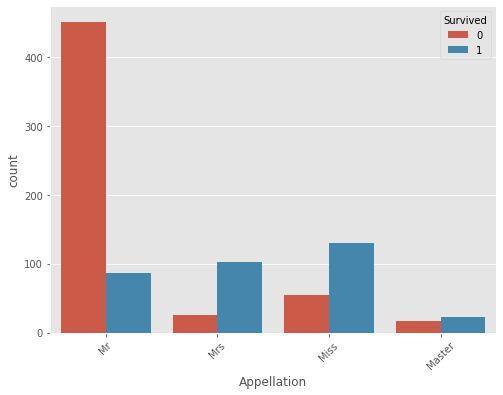

In [85]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Appellation', hue='Survived', data=train)
plt.xticks(rotation=45)

성인 남성('Mr')은 생존자 수보다 사망자 수가 매우 높은 반면, 여성('Mrs', 'Miss')과 남자 아이('Master')는 사망자 수보다 생존자 수가 높습니다.

### **Sex**

'Sex', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [31]:
pd.crosstab(train['Sex'], train['Survived'], margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


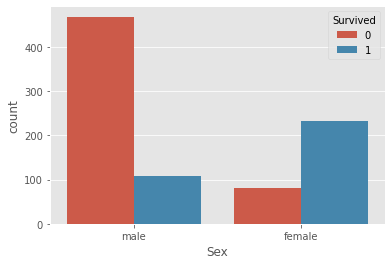

In [32]:
sns.countplot(x='Sex', hue='Survived', data=train)

남성 사망자 수가 훨씬 더 많습니다.

'Pclass'도 포함하여 살펴보겠습니다.

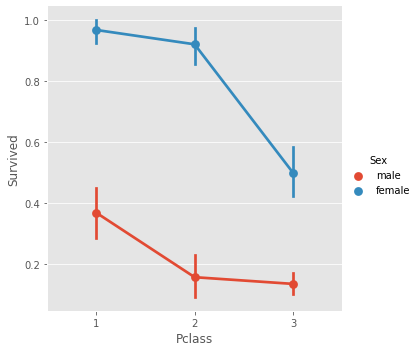

In [33]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='point')

등급이 높을수록 생존율이 높고 여성의 생존율이 더 높습니다.

### **Age**

'Age', 'Survived' 피처의 관계를 확인해 보겠습니다.

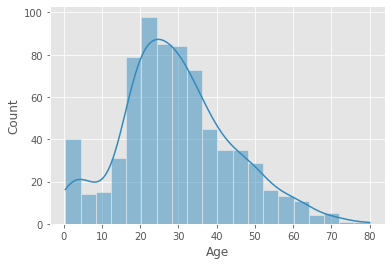

In [34]:
sns.histplot(x="Age", data=train, kde=True)

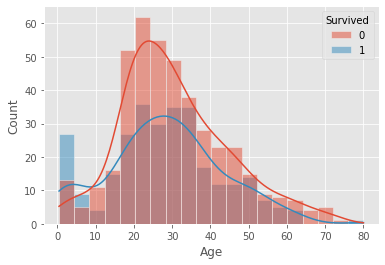

In [35]:
sns.histplot(x="Age", hue='Survived', data=train, kde=True)

10세 이하인 탑승객의 생존자 수가 높습니다. 나머지 연령대는 사망자 수가 더 많습니다.

비율로 변환해 보겠습니다.

Text(0, 0.5, 'Survival rate')

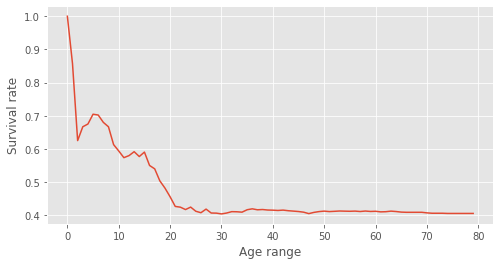

In [36]:
survived_age_rate = []

for i in range(1, 81):
    survived_age_rate.append(train[train['Age'] < i]['Survived'].sum() / len(train[train['Age'] < i]['Survived']))

plt.figure(figsize=(8, 4))
plt.plot(survived_age_rate)
plt.xlabel('Age range')
plt.ylabel('Survival rate')

나이가 어릴수록 생존율이 높습니다.

'Pclass', 'Sex', 'Age'간 분포를 함께 고려해 보겠습니다.

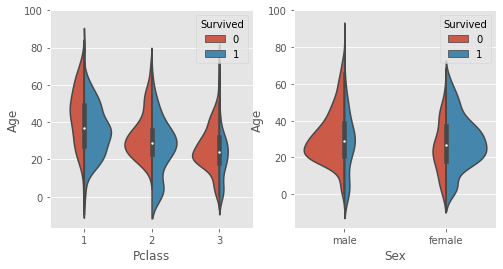

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=train, scale='count', split=True, ax=ax[0])
ax[0].set_yticks(range(0, 105, 20))

sns.violinplot(x='Sex', y='Age', hue='Survived', data=train, scale='count', split=True, ax=ax[1])
ax[1].set_yticks(range(0, 105, 20))

### **SibSp**

'SibSp', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [38]:
pd.crosstab(train['SibSp'], train['Survived'], margins=True)

Survived,0,1,All
SibSp,,,
0,398,210,608
1,97,112,209
2,15,13,28
3,12,4,16
4,15,3,18
5,5,0,5
8,7,0,7
All,549,342,891


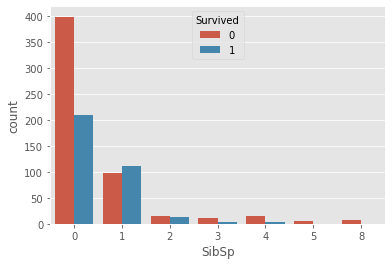

In [39]:
sns.countplot(x='SibSp', hue='Survived', data=train)

함께 승선한 형제나 배우자 수가 0명이면 사망자 수가 많습니다. 다만 1명을 제외하면 형제나 배우자 수가 많아지더라도 사망자 수가 오히려 높은 경향도 보입니다.

### **Parch**

'Parch', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [40]:
pd.crosstab(train['Parch'], train['Survived'], margins=True)

Survived,0,1,All
Parch,,,
0,445,233,678
1,53,65,118
2,40,40,80
3,2,3,5
4,4,0,4
5,4,1,5
6,1,0,1
All,549,342,891


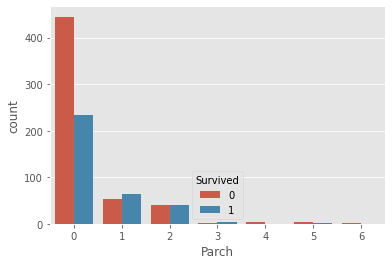

In [41]:
sns.countplot(x='Parch', hue='Survived', data=train)

함께 승선한 부모나 자녀의 수가 0명이면 사망자 수가 높습니다. 다만 부모나 자녀의 수가 많아질수록 오히려 사망자 수가 높은 경우도 존재합니다.

총 가족수로 살펴 보겠습니다.

In [42]:
train['Sum_sibsp_parch'] = train['SibSp'] + train['Parch']
pd.crosstab(train['Sum_sibsp_parch'], train['Survived'], margins=True)

Survived,0,1,All
Sum_sibsp_parch,,,
0,374,163,537
1,72,89,161
2,43,59,102
3,8,21,29
4,12,3,15
5,19,3,22
6,8,4,12
7,6,0,6
10,7,0,7


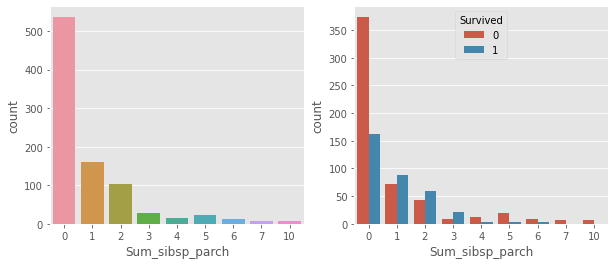

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x='Sum_sibsp_parch', data=train, ax=ax[0])
sns.countplot(x='Sum_sibsp_parch', hue='Survived', data=train, ax=ax[1])

plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [44]:
train[['Sum_sibsp_parch', 'Survived']].groupby(['Sum_sibsp_parch']).mean()

,Survived
Sum_sibsp_parch,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


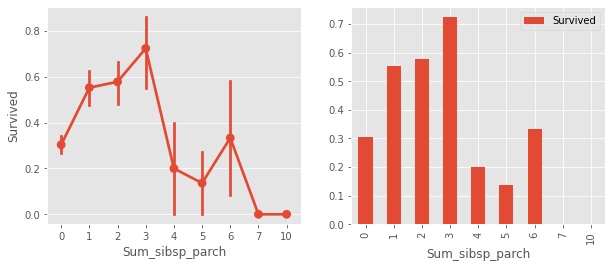

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.pointplot(x='Sum_sibsp_parch', y='Survived', data=train, ax=ax[0])
train[['Sum_sibsp_parch', 'Survived']].groupby(['Sum_sibsp_parch']).mean().plot.bar(ax=ax[1])

plt.subplots_adjust(wspace=0.2, hspace=0.2)

비슷한 경향을 보입니다. 적당한 가족 수여야 생존율이 높습니다. 너무 적거나 많으면 생존율이 떨어지는 경향을 보입니다.

### **Ticket**

'Ticket'의 고윳값은 681개입니다.

In [46]:
train['Ticket'].value_counts() 

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

몇 가지 규칙이 존재할 것으로 추정합니다.

### **Fare**

'Fare', 'Survived' 피처의 관계를 확인해 보겠습니다.

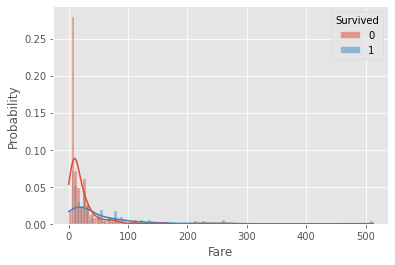

In [47]:
sns.histplot(x=train['Fare'], hue=train['Survived'], kde=True, stat='probability')

비싸지 않은 티켓일수록 생존자 수 차이가 큽니다. 확률밀도함수 그래프는 오른쪽 부분에 긴 꼬리 형태를 취하며 왜도가 큽니다. 자료가 왼쪽에 더 많이 분포해 있다는 것을 의미하기도 합니다. 왜도를 확인해 보겠습니다.

In [48]:
train['Fare'].skew()

4.787316519674893

양수이므로 오른쪽 방향의 긴 꼬리 형태를 보이는 것입니다. 정규분포로 변환할 필요가 있습니다.

### **Cabin**

마지막으로 'Cabin' 피처의 고윳값을 확인해 보겠습니다.

In [49]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [50]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

입력값이 일정하지 않고 결측치가 많으므로 사용할 수 없는 피처로 판단합니다. 피처 엔지니어링 때 피처 자체를 제거해야 옳습니다.

### **Embarked**

'Embarked', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [51]:
pd.crosstab(train['Embarked'], train['Survived'], margins=True)

Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,427,217,644
All,549,340,889


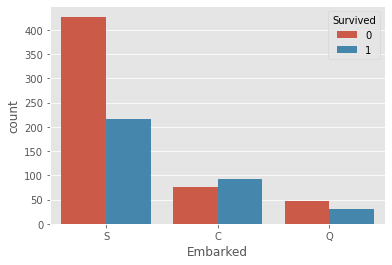

In [52]:
sns.countplot(x='Embarked', hue='Survived', data=train)

S의 경우 사망자 수가 월등히 높지만 다른 클래스는 사망과 생존의 비율이 약간 차이 나는 정도입니다.

생존율을 살펴보겠습니다.

In [53]:
train[['Embarked', 'Survived']].groupby(['Embarked']).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


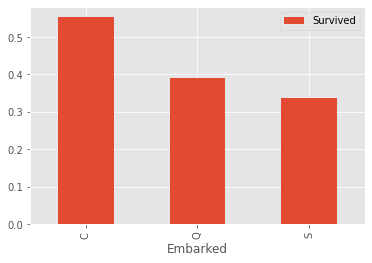

In [54]:
train[['Embarked', 'Survived']].groupby(['Embarked']).mean().plot.bar()

'C'의 생존률이 가장 높습니다.

## **피처 통계량 및 상관분석**

각 피처별 통계량을 확인해 보겠습니다.

In [55]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sum_sibsp_parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.904602
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


몇 피처와 'Survived' 피처 간 상관계수를 확인해 보겠습니다. 먼저 상관관계를 파악하려면 숫자가 아닌 피처를 수치화해야 합니다. 'Sex', 'Embarked', 'Appellation' 피처를 수치화하기 위해 원-핫 인코딩을 적용하겠습니다.

In [56]:
train_correlation_df = pd.get_dummies(train, columns=['Sex']) # 클래스가 2개이므로 `drop_first=True`를 지정하여 중복된 열을 제외해도 좋습니다.
train_correlation_df = pd.get_dummies(train_correlation_df, columns=['Embarked'])
train_correlation_df = pd.get_dummies(train_correlation_df, columns=['Appellation'])
train_correlation_df.head(3)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sum_sibsp_parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Appellation_Master,Appellation_Miss,Appellation_Mr,Appellation_Mrs
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,0,1,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,0,1,0,0,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,1,0,1,0,0


In [57]:
train_correlation = train_correlation_df.corr()
train_correlation

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sum_sibsp_parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Appellation_Master,Appellation_Miss,Appellation_Mr,Appellation_Mrs
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.040143,-0.042939,0.042939,-0.001205,-0.033606,0.022148,-0.026151,-0.067731,0.056143,0.015476
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.016639,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.085221,0.335636,-0.563879,0.347864
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.065997,-0.131900,0.131900,-0.243292,0.221009,0.081720,0.082081,-0.010261,0.090487,-0.162774
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.301914,-0.093254,0.093254,0.036261,-0.022405,-0.032523,-0.398827,-0.277827,0.272079,0.182501
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.890712,0.114631,-0.114631,-0.059528,-0.026354,0.070941,0.349559,0.083462,-0.261044,0.061130
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.783111,0.245489,-0.245489,-0.011069,-0.081228,0.063036,0.267344,0.100998,-0.354048,0.219080
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.217138,0.182333,-0.182333,0.269335,-0.117216,-0.166603,0.010908,0.119518,-0.182998,0.110532
Sum_sibsp_parch,-0.040143,0.016639,0.065997,-0.301914,0.890712,0.783111,0.217138,1.000000,0.200988,-0.200988,-0.046215,-0.058592,0.079977,0.372472,0.107500,-0.355291,0.151229
Sex_female,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,0.200988,1.000000,-1.000000,0.082853,0.074115,-0.125722,-0.159934,0.693916,-0.905908,0.555221
Sex_male,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,-0.200988,-1.000000,1.000000,-0.082853,-0.074115,0.125722,0.159934,-0.693916,0.905908,-0.555221


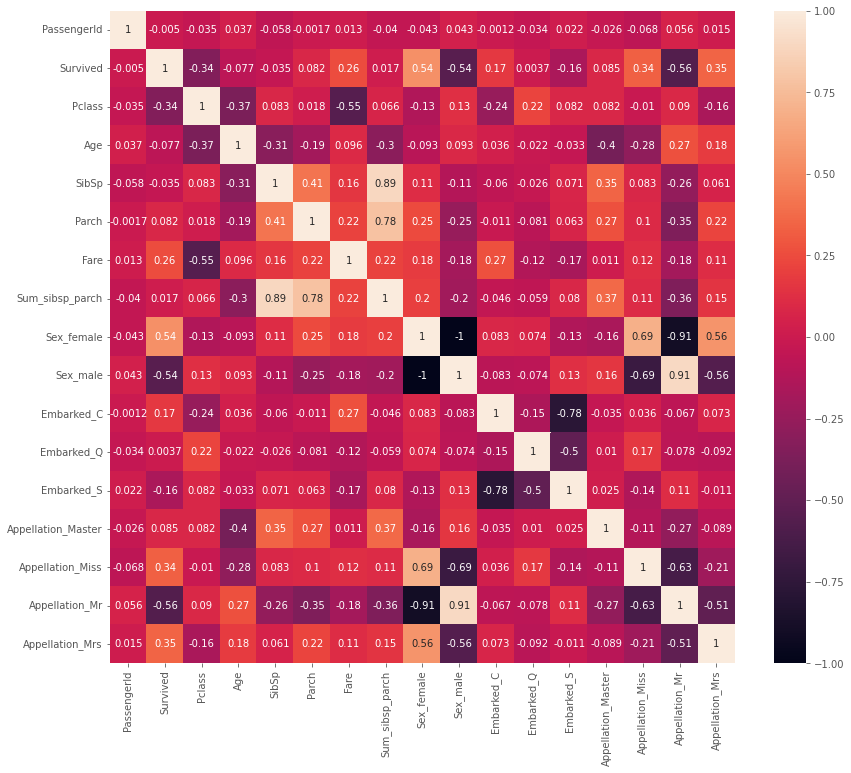

In [79]:
plt.figure(figsize=(14, 12))
sns.heatmap(train_correlation, annot=True)

- 상관관계가 가장 강한 피처는 'Appellation_Mr'입니다. 남성이 여성보다 사망률이 높으므로 음수를 나타냅니다.

- 두 번째는 'Sex_female', 'Sex_male'입니다. 여성이 남성보다 생존율이 높으므로 'Sex_female'은 양수를 나타냅니다. 

- 세 번째는 'Appellation_Mrs'입니다. 여성이 남성보다 생존율이 높으므로 양수를 나타냅니다. 

- 네 번째는'Pclass'입니다. 티켓 등급이 높을수록 생존율이 높고 티켓 등급이 낮을수록 생존율이 낮습니다. 'Appellation_Miss' 또한 네 번째입니다.

- 'Fare' 피처 또한 생존율에 영향을 주는 것으로 판단할 수 있습니다. 다만 'Age', 'Appellation_Master' 피처와의 상관관계가 매우 약한 것으로 나타납니다. 10세 이하의 생존율이 높은 점을 확인했으므로 이 지표만으로 상관관계가 약하다고 속단할 수 없습니다. 'Age' 피처의 경우 구간화(Binning)를 수행하여 몇 개의 피처로 나눠볼 수 있습니다.

# **기타 분석**

## **티켓 등급별 티켓 요금**

티켓 등급별 티켓 요금 분포를 확인해 보겠습니다. 

In [59]:
train[['Pclass', 'Fare']].groupby('Pclass').describe()

Fare                                                              
        count       mean        std  min       25%      50%   75%       max
Pclass                                                                     
1       216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292
2       184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000
3       491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500

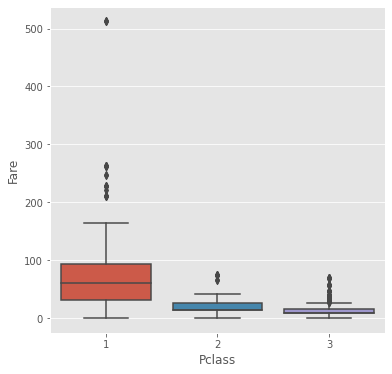

In [60]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='Pclass', y='Fare', data=train)

티켓 등급이 높을수록 티켓 요금이 매우 높습니다.

## **고가의 티켓에 7등급 부여**

상위 25% 이상인 고가의 티켓을 대상으로 새 피처를 생성하고 7(등급)을 부여하겠습니다.

In [61]:
# 새 피처를 생성합니다.
train['Gold_Pclass'] = train['Pclass']

# 새 피처에 7로 채웁니다.
train.loc[train['Fare'] > 93.5, 'Gold_Pclass'] = 7

티켓이 7등급인 승객을 확인해 보겠습니다.

In [62]:
train[train['Gold_Pclass']==7]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Appellation,Sum_sibsp_parch,Gold_Pclass
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,Mr,5,7
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,Mrs,1,7
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,Miss,5,7
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,Mr,1,7
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C,Miss,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,Miss,4,7
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S,Mrs,3,7
779,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S,Mrs,1,7
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S,Master,3,7


## **티켓 등급별 연령**

티켓 등급에 따라 어떤 연령대가 분포하는지 확인해 보겠습니다.

In [63]:
train[['Gold_Pclass', 'Age']].groupby('Gold_Pclass').describe()

Age                                                      
             count       mean        std   min    25%   50%    75%   max
Gold_Pclass                                                             
1            138.0  40.416667  14.305910  4.00  30.00  39.0  50.75  80.0
2            173.0  29.877630  14.001077  0.67  23.00  29.0  36.00  70.0
3            355.0  25.140620  12.495398  0.42  18.00  24.0  32.00  74.0
7             48.0  31.956667  14.550628  0.92  21.75  33.0  40.25  64.0

In [64]:
train[train['Age'] > 10][['Gold_Pclass', 'Age']].groupby('Gold_Pclass').describe()

Age                                                      
             count       mean        std   min    25%   50%    75%   max
Gold_Pclass                                                             
1            137.0  40.682482  14.012190  16.0  30.00  39.0  51.00  80.0
2            156.0  32.753205  11.497054  13.0  24.00  30.0  39.00  70.0
3            311.0  28.032154  10.452840  11.0  20.00  26.0  33.00  74.0
7             46.0  33.282609  13.341103  11.0  22.25  35.0  40.75  64.0

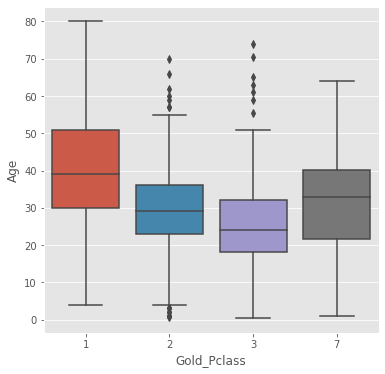

In [65]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='Gold_Pclass', y='Age', data=train)

나이가 많을수록 티켓 등급이 높아집니다. 최상 등급인 7등급 또한 2등급과 3등급보다 연령대가 높은 편입니다.

연령대와 티켓 등급의 분포를 확인해 보겠습니다.

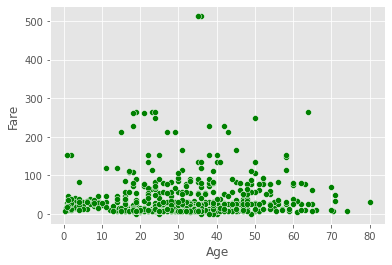

In [66]:
sns.scatterplot(x='Age', y='Fare', data=train, color='green')

티켓 등급은 다양한 연령대에 분포되어 있습니다.

## **티켓 등급별 승선자 수**

티켓 등급별 함께 승선한 사람수에 대한 분포를 확인해 보겠습니다.

In [67]:
# 두 피처 값을 합하면 함께 탑승한 총 인원이 됩니다.
train['All_sum'] = train['SibSp'] + train['Parch']
train[['Gold_Pclass', 'All_sum']].groupby('Gold_Pclass').describe()

All_sum                                               
              count      mean       std  min  25%  50%   75%   max
Gold_Pclass                                                       
1             163.0  0.521472  0.660503  0.0  0.0  0.0  1.00   2.0
2             184.0  0.782609  1.054017  0.0  0.0  0.0  1.25   5.0
3             491.0  1.008147  1.953525  0.0  0.0  0.0  1.00  10.0
7              53.0  1.547170  1.513605  0.0  0.0  1.0  2.00   5.0

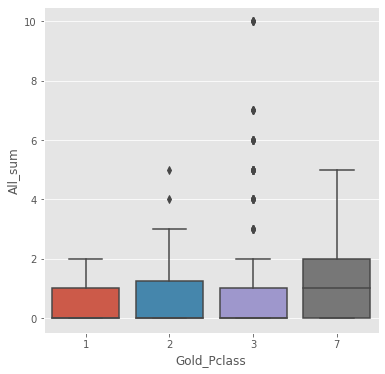

In [68]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='Gold_Pclass', y='All_sum', data=train)

7등급 티켓의 경우 함께 탑승한 인원의 평균이 1 이상인 약 1.5이므로 함께 탑승한 비율이 높다고 판단할 수 있습니다. 1등급 티켓의 경우 함께 탑승한 인원의 평균이 약 0.5로 가장 낮습니다. 3등급 티켓의 경우 이상치로써 많은 탑승객이 함께 탄 것으로 확인됩니다.

## **티켓 등급별 성별**

티켓 등급별 성별 분포를 확인해 보겠습니다.

In [69]:
gold_pclass_sex = train[['Gold_Pclass', 'Sex', 'PassengerId']].groupby(['Gold_Pclass', 'Sex']).count().unstack()
gold_pclass_sex

PassengerId     
Sex              female male
Gold_Pclass                 
1                    60  103
2                    76  108
3                   144  347
7                    34   19

In [70]:
gold_pclass_sex['female_ratio'] = gold_pclass_sex['PassengerId', 'female'] / (gold_pclass_sex['PassengerId', 'female'] + gold_pclass_sex['PassengerId', 'male'])
gold_pclass_sex['male_ratio'] = gold_pclass_sex['PassengerId', 'male'] / (gold_pclass_sex['PassengerId', 'female'] + gold_pclass_sex['PassengerId', 'male'])
gold_pclass_sex

PassengerId      female_ratio male_ratio
Sex              female male                        
Gold_Pclass                                         
1                    60  103     0.368098   0.631902
2                    76  108     0.413043   0.586957
3                   144  347     0.293279   0.706721
7                    34   19     0.641509   0.358491

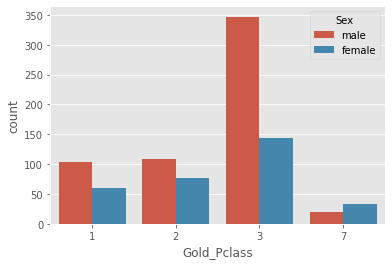

In [71]:
sns.countplot(x='Gold_Pclass', hue='Sex', data=train)

## **티켓 등급별 승선 항구**

승선 항구별 티켓 등급 분포를 확인해 보겠습니다.

In [72]:
pd.crosstab(train['Gold_Pclass'], train['Embarked'], margins=True)

Embarked,C,Q,S,All
Gold_Pclass,,,,
1,56,2,103,161
2,17,3,164,184
3,66,72,353,491
7,29,0,24,53
All,168,77,644,889


In [73]:
gold_pclass_embarked = pd.crosstab(train['Gold_Pclass'], train['Embarked'], margins=True)
gold_pclass_embarked

Embarked,C,Q,S,All
Gold_Pclass,,,,
1,56,2,103,161
2,17,3,164,184
3,66,72,353,491
7,29,0,24,53
All,168,77,644,889


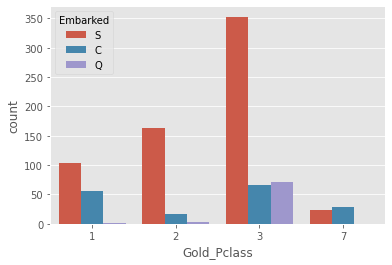

In [74]:
sns.countplot(x='Gold_Pclass', hue='Embarked', data=train)

In [75]:
gold_pclass_embarked['All_sum_embarked'] = gold_pclass_embarked['C'] + \
gold_pclass_embarked['Q'] + gold_pclass_embarked['S']
gold_pclass_embarked['S'] = gold_pclass_embarked['S'] / gold_pclass_embarked['All_sum_embarked']
gold_pclass_embarked['C'] = gold_pclass_embarked['C'] / gold_pclass_embarked['All_sum_embarked']
gold_pclass_embarked['Q'] = gold_pclass_embarked['Q'] / gold_pclass_embarked['All_sum_embarked']

gold_pclass_embarked = gold_pclass_embarked.drop(['All_sum_embarked'], axis=1)
gold_pclass_embarked = gold_pclass_embarked.drop(['All'], axis=1)

gold_pclass_embarked

Embarked,C,Q,S
Gold_Pclass,,,
1,0.347826,0.012422,0.639752
2,0.092391,0.016304,0.891304
3,0.134420,0.146640,0.718941
7,0.547170,0.000000,0.452830
All,0.188976,0.086614,0.724409


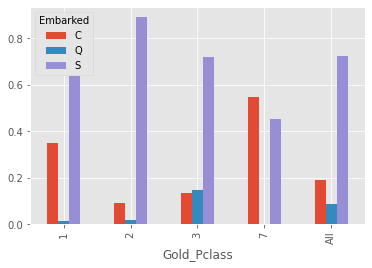

In [76]:
gold_pclass_embarked.plot.bar()

각 항구와 티켓 등급마다 승선한 비율에 차이가 뚜렷합니다. 가장 많이 승선한 비율은 S 항구이고 Q 항구에서는 거의 승선하지 않았지만 3등급의 경우 다른 등급보다 Q 항구에서 많이 승선한 편입니다.

추가로 분석할 수 있지만 이 정도에서 마무리하겠습니다.

# **결론**

- 질적 변수('Pclass', 'Name', 'Sex', 'Parch')는 원-핫 인코딩으로 처리할 필요가 있습니다. 'Name' 피처는 호칭을 따로 분리하여 새 피처를 생성해야 합니다. 

- 양적 변수 중 'Age'는 구간화(Binning)를 수행하여 몇 개의 피처로 나눠볼 수 있습니다. 'Fare'는 왜도가 크므로 로그 변환을 통해 정규화를 수행할 필요가 있습니다. 

- 결측치가 존재하는 피처는 'Age', 'Fare', 'Cabin', 'Embarked'입니다. 평균값, 최빈값, 중간값 중 적절한 값으로 대체하되 특정 그룹을 기준으로 삼거나 전체 값을 기준으로 삼을지 결정해야 합니다. 'Cabin' 피처는 결측치가 많고 입력값이 일정치 않아 사용하기 어려우므로 삭제하는 편이 옳다고 판단합니다.

- 추가로 타깃값 예측력이 낮거나 예측에 도움이 되지 않을 피처는 제거하는 편이 좋습니다. 'PassengerId' 피처가 대표적이며, 'Ticket' 피처는 제거 여부를 고려해야 합니다.